In [2]:
#Dependencies
import graspy
import pdb
import myModule
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from utils import cartprod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import random
%matplotlib inline
from graspy.simulations import sbm
from graspy.plot import heatmap
np.random.seed(10)

#Generating simulation/test data
def data_generator(num_graphs, N, n, prob_vec, percent_vec):
    
    #Create empty tensor for data to be added to,
    #as well as tensors to store each data type
    
    num_types = len(percent_vec)
    num = [int(num_graphs * a) for a in percent_vec]
    
    data = np.zeros((num_graphs,N,N))
    y_label = np.zeros((num_graphs,1))
    p_tensor = np.zeros((num_types,N,N))
    
    L_ind = random.sample(range(0, num_graphs), num_graphs)
    
    for i in range(num_types):
        types = np.zeros((num[i],N,N))
        
        for j in range(len(types)):
            types[j] = sbm(n=n, p=prob_vec[i])
        data[L_ind[:num[i]]] = types
        y_label[L_ind[:num[i]]] = i
        L_ind = L_ind[num[i]:]
        
        prob_mat = 2*np.ones((1,N))
        for k in range(len(n)):
            count = 0
            first_row = 2*np.ones((1,N))
            for L in range(len(n)):
                vec = np.repeat(prob_vec[i][k][L],n[L])
                first_row = np.append(first_row,vec)
                first_row = first_row[first_row != 2]
            first_row = np.tile(first_row, (n[k],1))
            prob_mat = np.vstack( (prob_mat, first_row) )
        p_tensor[i] = prob_mat[1:]
            
    y_label = y_label.astype(int)
    #y_label = y_label.tolist()
    
    return data, y_label, p_tensor

def mat_likelihood(A, P_hat, domain):
    A_complement = 1 - A
    P_hat_complement = 1 - P_hat
    
    dim = len(P_hat)
    
    outputs = np.zeros(dim)
    
    #print(P_hat)
    #print(A)
    
    types_ = 0
    count = 1
    for i in range(dim):
        intermediate = np.log(np.multiply(np.power(P_hat[i], A), np.power(P_hat_complement[i], A_complement)))
        intermediate = np.triu(intermediate)
        intermediate = intermediate[domain]
        val = np.sum(intermediate)
        if i == 0:
            final = val
        elif val > final:
            final = val
            types_ = i
        else:
            continue
    
    return types_    

def classifier_method(num_graphs, N, percent_vec, prob_tensor, ss_m_n, A_data, y_label):
    vals = range(len(percent_vec))
    
    num = num_graphs * percent_vec
    
    ind = np.asarray([np.where(y_label == i)[0] for i in vals])
    
    data_subsets = np.asarray([data[j] for j in ind])
    
    sums = np.asarray([np.sum(a, 0) for a in data_subsets])
    
    P_hat_vec = np.asarray([np.true_divide(sums[b],num[b]) for b in range(len(num))])
    
    label_estimate = np.zeros(num_graphs)
    for i in range(len(A_data)):
        label_estimate[i] = mat_likelihood(A_data[i], P_hat_vec, ss_m_n)

    return label_estimate

def non_iterative_screen(a_tensor, N, y_labels, c, opt):

    '''
    Performs iterative screening on graphs.

    Parameters

    ----------
    
    a_tensor: tensor of adjacency matrices that are going to be used for signal subgraph.

    mat_n_m: Length/width of the adjacency matrices in the dictionary
    
    y_labels: the vector of labels.
    
    c: the correlation threshold value.
    
    opt: indicator of whether to use dcorr or mgc

    Returns

    -------

    values_flags: the signal subgraph of a_matrix, found through non-iterative

    vertex screening.
    '''
    mgc = MGC()
    dcorr = DCorr(which_test = 'unbiased')
    rvcorr = RVCorr()
    count = len(a_tensor)
    S_hat = np.zeros((count,1))
    
    #Creates matrices by stacking the nth rows on top of each other and running mgc on those with their 
    #corresponding labels.
    for i in range(len(a_tensor)):
        mat = a_tensor[:,i]
        #data[y_label_class[:,0].astype(int)][0]
        if opt == "mgc":
            c_u_0, independence_test_metadata_0 = mgc.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_0
        elif opt == "dcorr":
            c_u_1, independence_test_metadata_1 = dcorr.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_1
        else:
            c_u_2, independence_test_metadata_1 = rvcorr.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_2
    
    S_hat = np.absolute(S_hat)
    S_hat = S_hat[:,0]
    #as_vec = np.sort(S_hat.reshape(1,200)).reshape(200,1)
    #list_comp = as_vec[-20:]
    #values_flags = []
    #for i in range(20):
    #    values_flags.append(np.where(S_hat == list_comp[i])[0][0])
    largest = S_hat.argsort()[-20:][::-1]
    values_flags = np.nonzero(S_hat > c)
    
    return np.asarray(values_flags[0][:]) #, largest
    

def iterative_screen(a_tensor, N, y_labels, delta, opt):

    '''
    Performs iterative screening on graphs.

    Parameters

    ----------
    
    a_tensor: tensor of adjacency matrices that are going to be used for signal subgraph.

    mat_n_m: Length/width of the adjacency matrices in the dictionary
    
    y_labels: the vector of labels.
    
    delta: quantile to be screened
    
    opt: indicator of whether to use dcorr or mgc

    Returns

    -------

    values_flags: the signal subgraph of a_matrix, found through non-iterative

    vertex screening.
    '''
    mgc = MGC()
    dcorr = DCorr(which_test = 'unbiased')
    rvcorr = RVCorr()
    count = len(a_tensor)
    S_hat = np.zeros((count,1))
    
    V = np.arange(200)
    
    while V.size > 1:
        c_u_list = []
        for i in V:
            c_u, independence_test_metadata = mgc.test_statistic(a_tensor[:,i], y_labels)
            c_u_list.append(abs(c_u))
        t_k = np.quantile(c_u_list, .50, axis = 0)
        ind = [i for i,j in enumerate(c_u_list) if j > t_k]
        V = V[ind]
        print(V)

    c_k, independence_test_metadata = mgc.test_statistic(a_tensor[:,V[0]], y_labels)
    #k_* = np.argmax()
    
    return V, c_k

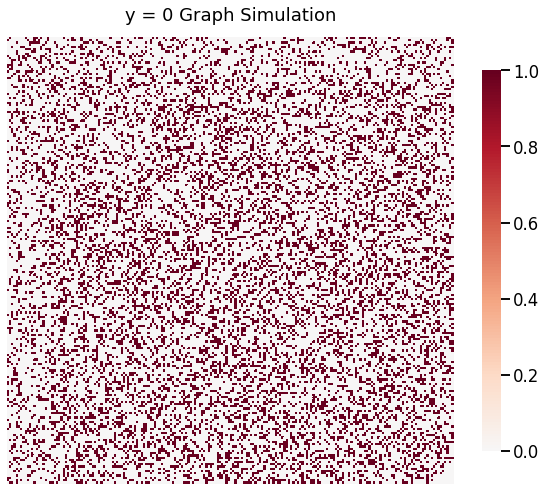

<Figure size 432x288 with 0 Axes>

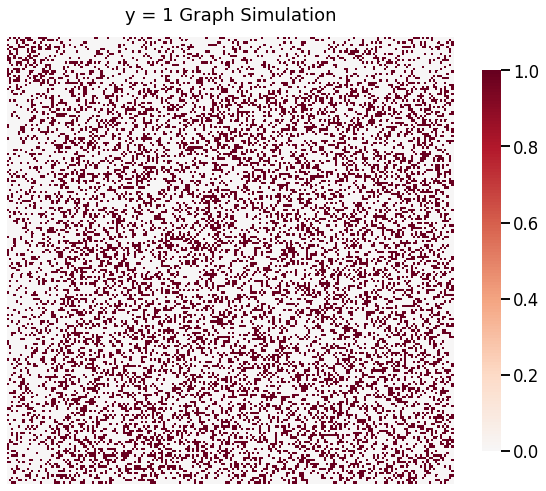

In [3]:
# Make Simulation Data
prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[.3, .2], [.2, .3]]
prob_tensor[1] = [[.4, .2], [.2, .3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

#Can't make too little graphs otherwise will have to deal with dividing by zero problem!!

data, y_label, p_data = data_generator(200, 200, n, prob_tensor, percent_vec)
#y_label_class = y_label.reshape(100,1).astype(float)

#Plot
heatmap(data[np.where(y_label == 0)[0]][0], title='y = 0 Graph Simulation')

plt.figure()
heatmap(data[np.where(y_label == 1)[0]][1], title='y = 1 Graph Simulation')

In [758]:
mat = np.sum(data[np.where(y_label == 0)[0]], 0)
vec = 100 * np.asarray([0.5, 0.5])
print(mat[7])
tense = np.asarray([np.true_divide(mat, vec[a]) for a in range(len(vec))])
print(tense[0][7])
#print(np.sum(data[np.where(y_label == 0)[0]], 0))
#print(np.sum(data, 0)[2])]

[2. 4. 6. 4. 3. 4. 2. 0. 5. 4. 3. 2. 3. 3. 0. 3. 0. 2. 4. 3. 3. 1. 1. 3.
 3. 1. 4. 2. 0. 0. 0. 0. 0. 2. 1. 1. 0. 3. 0. 2. 1. 1. 7. 4. 3. 2. 2. 2.
 1. 1. 0. 4. 2. 2. 1. 1. 3. 1. 0. 2. 1. 5. 4. 0. 2. 0. 2. 2. 0. 2. 1. 3.
 2. 3. 0. 1. 2. 0. 2. 1. 2. 2. 1. 1. 3. 1. 5. 3. 2. 1. 5. 2. 2. 1. 3. 1.
 0. 3. 2. 1. 3. 4. 3. 3. 0. 3. 2. 4. 2. 4. 1. 3. 2. 3. 1. 1. 2. 2. 2. 0.
 1. 2. 5. 1. 3. 2. 4. 2. 2. 1. 0. 3. 2. 4. 1. 2. 3. 4. 3. 0. 3. 4. 1. 1.
 3. 1. 3. 2. 1. 0. 3. 3. 1. 1. 0. 2. 2. 4. 1. 3. 2. 3. 2. 1. 2. 2. 0. 2.
 2. 1. 4. 1. 1. 2. 1. 3. 4. 5. 3. 1. 1. 1. 2. 3. 3. 2. 3. 3. 2. 3. 2. 2.
 2. 2. 4. 1. 1. 2. 4. 0.]
[0.04 0.08 0.12 0.08 0.06 0.08 0.04 0.   0.1  0.08 0.06 0.04 0.06 0.06
 0.   0.06 0.   0.04 0.08 0.06 0.06 0.02 0.02 0.06 0.06 0.02 0.08 0.04
 0.   0.   0.   0.   0.   0.04 0.02 0.02 0.   0.06 0.   0.04 0.02 0.02
 0.14 0.08 0.06 0.04 0.04 0.04 0.02 0.02 0.   0.08 0.04 0.04 0.02 0.02
 0.06 0.02 0.   0.04 0.02 0.1  0.08 0.   0.04 0.   0.04 0.04 0.   0.04
 0.02 0.06 0.04 0.06 0.   0.02 0.04

In [17]:
import sklearn.metrics as metrics
c = np.linspace(0.006, 0.015, num=32)
#c = [0.01, 0.02]
tensor_labels = np.zeros((0, 1, 100))
#counter = 0
for i in c:

    ss_m_n = non_iterative_screen(data, 200, y_label, i, "mgc")
    
    print(ss_m_n)
    
    #test_labels = classifier_method(200, 200, percent_vec, p_data, ss_m_n, data, y_label)

    #tensor_labels = np.append(tensor_labels,test_labels)
    
tensor_labels = tensor_labels.reshape((32,1,200))
#print(ss_m_n)    
#print(tensor_labels)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  25  27  29  32  35  37  43  45  51  52  54  55  58  60  63  66
  67  69  70  71  72  73  75  76  78  79  80  86  89  90  92  95 107 108
 109 111 114 116 118 122 123 124 125 126 129 130 135 136 138 141 149 150
 153 154 156 162 164 166 167 172 173 176 177 182 183 186 188 189 191 195
 199]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  25  27  29  32  35  37  43  45  51  52  54  55  60  63  66  67
  69  70  71  73  75  76  78  79  80  86  89  90  92 108 109 111 114 116
 118 122 123 124 126 129 130 135 136 138 141 149 150 153 156 162 164 166
 167 172 173 176 177 182 183 186 188 189 191 195 199]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18
  19  25  27  29  32  35  37  43  45  51  52  54  60  63  66  67  69  70
  71  73  75  76  78  79  80  86  89  90  92 108 109 114 116 118 122 123
 126 129 130 135 136 138 149 150 153 156 162 166 167 172 173 176

ValueError: cannot reshape array of size 0 into shape (32,1,200)

In [15]:
#tensor_labels = tensor_labels.reshape((32,1,100))
#tensor_labels = tensor_labels.reshape((3,1,200))
print(tensor_labels)
#print(y_label)

[[[1. 0. 1. ... 1. 0. 1.]]

 [[1. 0. 1. ... 1. 0. 1.]]

 [[1. 0. 1. ... 1. 0. 1.]]

 ...

 [[1. 0. 1. ... 1. 0. 1.]]

 [[1. 0. 1. ... 1. 0. 1.]]

 [[1. 0. 1. ... 1. 0. 1.]]]


100
1.0
0.0
0
100
1.0
0.0
1
100
1.0
0.0
2
100
1.0
0.0
3
100
1.0
0.0
4
100
1.0
0.0
5
100
1.0
0.0
6
100
1.0
0.0
7
100
1.0
0.0
8
100
1.0
0.0
9
100
1.0
0.0
10
100
1.0
0.0
11
100
1.0
0.0
12
100
1.0
0.0
13
100
1.0
0.0
14
100
1.0
0.0
15
100
1.0
0.0
16
100
1.0
0.0
17
100
1.0
0.0
18
100
1.0
0.0
19
100
1.0
0.0
20
100
1.0
0.0
21
100
1.0
0.0
22
100
1.0
0.0
23
100
1.0
0.0
24
100
1.0
0.0
25
100
1.0
0.0
26
100
1.0
0.0
27
100
1.0
0.0
28
100
1.0
0.0
29
100
1.0
0.0
30
100
1.0
0.0
31
0.0


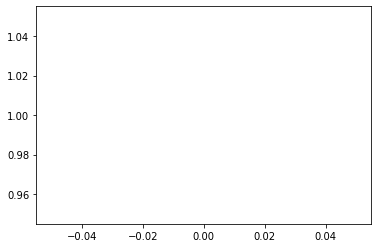

In [16]:
false_pos_list = []
true_pos_list = []
for i in range(len(tensor_labels)):
    list_test_labels = np.ndarray.tolist(tensor_labels[i][0])
    list_test_labels = [int(i) for i in list_test_labels]
    #fpr, tpr, threshold = metrics.roc_curve(list_test_labels, y_label)
    count = 0
    tpr = 0 
    fpr = 0
    for j in range(len(list_test_labels)):
        if list_test_labels[j] == 1:
            if y_label[j] == 1: 
                tpr += 1
            if y_label[j] == 0: 
                fpr += 1
    print(sum(list_test_labels))
    
    tpr = tpr / sum(list_test_labels)
    
    if sum(list_test_labels) == 200:
        fpr = 0
    else:
        fpr = fpr / (200 - sum(list_test_labels))
    
    print(tpr)
    print(fpr)
    print(i)
    false_pos_list.append(1 - tpr)
    true_pos_list.append(tpr)

print(metrics.auc(false_pos_list, true_pos_list))
plt.plot(false_pos_list, true_pos_list)

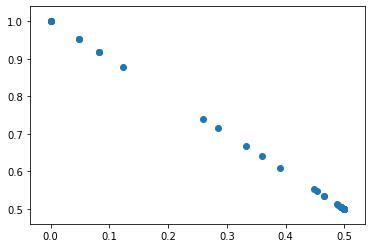

In [824]:
plt.scatter(false_pos_list, true_pos_list)

In [350]:
iterative_screen(data, 200, y_label.reshape(100,1), 0.05, "mgc")

[  0   3   4   5   7   8   9  10  11  12  13  14  15  17  21  23  24  26
  30  31  35  37  39  41  42  43  45  47  48  49  54  55  57  58  59  60
  61  64  68  70  71  72  75  76  77  78  79  80  81  83  84  96  97 100
 102 105 106 113 116 119 121 123 124 125 127 128 131 133 135 137 139 140
 141 142 143 146 148 149 151 153 154 159 161 163 164 166 168 173 175 179
 184 185 186 187 188 189 190 191 192 196]
[  0   3   4   5   7   8   9  11  12  13  14  23  31  35  39  48  49  54
  55  57  58  59  70  71  77  80  83  84  97 100 106 116 119 121 123 124
 128 131 133 139 140 146 154 159 161 179 184 185 187 188]
[  3   4   5   7   9  11  12  13  14  48  49  54  70  71  80  83  84 121
 133 139 140 179 185 187 188]
[  3   4   7   9  11  12  14  49  54 133 185 188]
[  3   4   9  12  49 133]
[  4  49 133]
[133]


(array([133]), 0.06289007100742133)

In [1605]:
non_iterative_screen(data, 200, y_label_class, 0.092, "cca")

array([ 0,  4,  6, 10, 11, 12, 13, 14, 15, 20, 26, 60, 73, 89])

In [1594]:
non_iterative_screen(data, 200, y_label_class, 0.02, "dcorr")

array([ 0,  4, 10, 11, 14, 15, 21, 48, 60, 73, 89, 90, 92])

In [1595]:
non_iterative_screen(data, 200, y_label_class, 0.02, "mgc")

array([ 0,  4, 10, 11, 14, 15, 21, 48, 60, 73, 90, 92, 99])

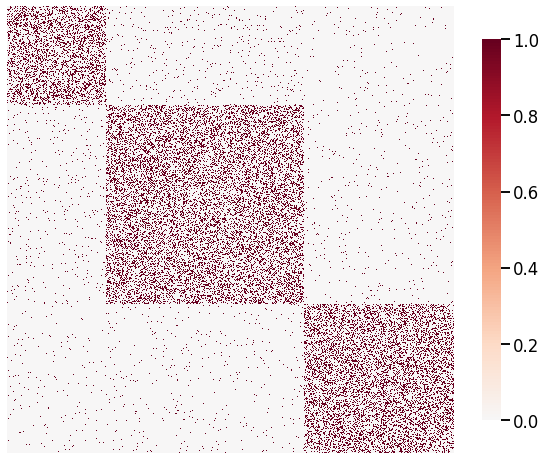

In [33]:
mat = prob_tensor[0]
#test = 
np.kron(mat, np.eye(4, 4))

matrix = [[.3, .02, .01], [.02, .3, .0125], [.01, .0125, .31]]
n = [200, 400, 300]
matrick = sbm(n=n,p=matrix)
heatmap(matrick)

In [312]:
first = np.array([[1,2,3,4],[5,6,7,8]])
second = np.array([[5,5,7,8]])
#first = first[ first != 2 ]
#first = first.reshape(7,1)
#print(first)
#np.tile(first, (3,1))
#np.append(first[0],second)
#np.array((1,2,3))
#second = second[second != 5]
#print(second)
#np.vstack( (first, second) )
#second = np.delete(second, ind_two)
#print(first)

In [313]:
np.prod(first)

40320

In [481]:
tensor_test = 3 - np.ones((4,4,4))
tensor_test_2 = np.ones((4,4))
lister = []
lister.append(tensor_test)
lister.append(tensor_test_2)
np.sum([i for i in tensor_test], 0)
lister = np.asarray(lister)
#np.matrix.sum(tensor_test)
mock = np.asarray([2,3])
print(lister[[0]][0][0]) #[mock]) #[0,1]) #[mock])

ValueError: could not broadcast input array from shape (4,4,4) into shape (4,4)

In [522]:
tensor_test = 4 - np.ones((4,4,4))
tensor_test[1] = [[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]]
test = [[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]]
tensor_test_2 = 3 - np.ones((4,4))
np.power(tensor_test_2,tensor_test)
vec = 1 + np.ones(4)
vec[0] = 5
print(vec.shape)
thing = np.asarray([test / (2 * a) for a in vec])
print(thing)

(4,)
[[[0.1  0.2  0.3  0.4 ]
  [0.1  0.2  0.3  0.4 ]
  [0.1  0.2  0.3  0.4 ]
  [0.1  0.2  0.3  0.4 ]]

 [[0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]]

 [[0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]]

 [[0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]
  [0.25 0.5  0.75 1.  ]]]


Text(0.5, 0, 'Threshold Value (unitless)')

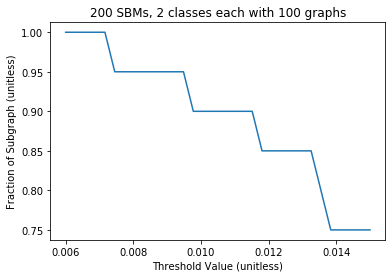

In [22]:
frac_array = [1, 1, 1, 1, 1, .95, .95, .95, .95, .95, .95, .95, .95, .90, .9, .9, .9, .9, .9, .9, .85, .85, .85, .85, .85, .85, 0.80, 0.75, 0.75, 0.75, 0.75, 0.75]
plt.plot(c, frac_array)
plt.title("200 SBMs, 2 classes each with 100 graphs")
plt.ylabel("Fraction of Subgraph (unitless)")
plt.xlabel("Threshold Value (unitless)")